# The Phillips curve

In this data project we want to plot two "Phillips curve", one with inflation and one regarding expected inflation. Historically inflations has been used when making Phillips curves, but new keynisian theories suggest that the difference between actual inflation and expected inflation has a stronger correlation with unemployment rates. We therefore expect to find a stronger correlation, and therefore a better regression, in the Phillips curve regarding expected inflation. 
Since we couldn´t find data for expected inflation we assume the expected inflation is approx the same as inflation the year prior.
The inflation is calculated from consumer price index. Furthermore we use seasonally adjusted data for unemployement rate.

Imports and set magics:

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dstapi import DstApi
import plotly.express as px
import seaborn as sns

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

# Unemployment data

We start out by importing the uneployment data (seasonally adjusted). We import it by using API, we therefore import the data directly for DST. 

In [138]:
# We create an dst api **object** that will allow us to interact with the DST server. 
AUS = DstApi('AUS09') 

# A quick overview of the available data
tabsum = AUS.tablesummary(language='en')
display(tabsum)

Table AUS09: Unemployment indicator by type of benefits, seasonal adjustment and actual figures and time
Last update: 2024-04-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,YDELSESTYPE,3,TOT,Gross unemployment,LKM,Unemployed recipients of social assistance,False
1,SAESONFAK,4,9,Seasonally adjusted figures in percent of the ...,24,Enumerated actual figures,False
2,Tid,207,2007M01,2007M01,2024M03,2024M03,True


In [139]:
# The available values for each variable: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(AUS.variable_levels(variable, language='en'))

YDELSESTYPE:


,id,text
0,TOT,Gross unemployment
1,LDM,Unemployed recipients of unemployment benefits
2,LKM,Unemployed recipients of social assistance


SAESONFAK:


,id,text
0,9,Seasonally adjusted figures in percent of the ...
1,10,Seasonally adjusted
2,22,Enumerated actual figures in percent of the l...
3,24,Enumerated actual figures


Tid:


,id,text
0,2007M01,2007M01
1,2007M02,2007M02
2,2007M03,2007M03
3,2007M04,2007M04
4,2007M05,2007M05
...,...,...
202,2023M11,2023M11
203,2023M12,2023M12
204,2024M01,2024M01
205,2024M02,2024M02


In [140]:
# Use the _define_base_params -method to get a nice template (selects all available data)
params = AUS._define_base_params(language='en')
params

{'table': 'aus09',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'YDELSESTYPE', 'values': ['*']},
  {'code': 'SAESONFAK', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [141]:
# We define what we want the dataset to contain
params = {'table': 'aus09',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'YDELSESTYPE', 'values': ['TOT']},
  {'code': 'SAESONFAK', 'values': ['9']},
  {'code': 'Tid', 'values': ['*']}]}

In [142]:
# We load the data from dst via the api using the options specified in the param dictionary 
unemployment = AUS.get_data(params=params)
unemployment.head(5)

,YDELSESTYPE,SAESONFAK,TID,INDHOLD
0,Gross unemployment,Seasonally adjusted figures in percent of the ...,2024M01,2.9
1,Gross unemployment,Seasonally adjusted figures in percent of the ...,2007M05,3.8
2,Gross unemployment,Seasonally adjusted figures in percent of the ...,2011M02,6.0
3,Gross unemployment,Seasonally adjusted figures in percent of the ...,2011M07,6.0
4,Gross unemployment,Seasonally adjusted figures in percent of the ...,2012M05,6.2


In [143]:
# We sort the data so it is in chronological order
unemployment = unemployment.sort_values(by='TID')
print(unemployment)

            YDELSESTYPE                                          SAESONFAK  \
192  Gross unemployment  Seasonally adjusted figures in percent of the ...   
115  Gross unemployment  Seasonally adjusted figures in percent of the ...   
37   Gross unemployment  Seasonally adjusted figures in percent of the ...   
72   Gross unemployment  Seasonally adjusted figures in percent of the ...   
1    Gross unemployment  Seasonally adjusted figures in percent of the ...   
..                  ...                                                ...   
100  Gross unemployment  Seasonally adjusted figures in percent of the ...   
64   Gross unemployment  Seasonally adjusted figures in percent of the ...   
0    Gross unemployment  Seasonally adjusted figures in percent of the ...   
71   Gross unemployment  Seasonally adjusted figures in percent of the ...   
136  Gross unemployment  Seasonally adjusted figures in percent of the ...   

         TID INDHOLD  
192  2007M01     4.3  
115  2007M02     

In [144]:
# We reset the index
unemployment.reset_index(drop=True, inplace=True)
print(unemployment)

            YDELSESTYPE                                          SAESONFAK  \
0    Gross unemployment  Seasonally adjusted figures in percent of the ...   
1    Gross unemployment  Seasonally adjusted figures in percent of the ...   
2    Gross unemployment  Seasonally adjusted figures in percent of the ...   
3    Gross unemployment  Seasonally adjusted figures in percent of the ...   
4    Gross unemployment  Seasonally adjusted figures in percent of the ...   
..                  ...                                                ...   
202  Gross unemployment  Seasonally adjusted figures in percent of the ...   
203  Gross unemployment  Seasonally adjusted figures in percent of the ...   
204  Gross unemployment  Seasonally adjusted figures in percent of the ...   
205  Gross unemployment  Seasonally adjusted figures in percent of the ...   
206  Gross unemployment  Seasonally adjusted figures in percent of the ...   

         TID INDHOLD  
0    2007M01     4.3  
1    2007M02     

In [145]:
# We delete the last two rows
unemployment = unemployment[:-3]

# We drop the variables "YDELSESTYPE" and "SAESONFAK"
unemployment = unemployment.drop(columns=['YDELSESTYPE', 'SAESONFAK'])

# We rename "TID" and "INDHOLD"
unemployment.rename(columns = {"TID": "year_month","INDHOLD": "unemployment"},  inplace =True)
print(unemployment)

    year_month unemployment
0      2007M01          4.3
1      2007M02          4.1
2      2007M03          3.9
3      2007M04          3.9
4      2007M05          3.8
..         ...          ...
199    2023M08          2.8
200    2023M09          2.8
201    2023M10          2.8
202    2023M11          2.9
203    2023M12          2.9

[204 rows x 2 columns]


We now have a dataset for unemployment that goes from primo 2007 to ultimo 2023

# Consumer price index

We import data for consumer price index by downloading the dataset from DST as a .csv file. 

In [146]:
# we save the dataset as "data" 
PRIS = 'PRIS113.csv'

# we skip the first 322 rows
index = pd.read_csv(PRIS, sep=';', skiprows=299)
index.head(5)


,2004M12,82.6
0,2005M01,82.4
1,2005M02,83.2
2,2005M03,83.7
3,2005M04,84.1
4,2005M05,84.1


In [147]:
# We delete the last two rows
index = index[:-2]
index.tail(5)

,2004M12,82.6
223,2023M08,117.7
224,2023M09,117.4
225,2023M10,117.7
226,2023M11,117.3
227,2023M12,116.7


Now our dataset goes fromn 2005M01 to 2023M12

In [148]:
# We rename our variables
index.rename(columns = {"2004M12": "year_month","82.6": "cp_index"},  inplace =True)
print(index)

    year_month  cp_index
0      2005M01      82.4
1      2005M02      83.2
2      2005M03      83.7
3      2005M04      84.1
4      2005M05      84.1
..         ...       ...
223    2023M08     117.7
224    2023M09     117.4
225    2023M10     117.7
226    2023M11     117.3
227    2023M12     116.7

[228 rows x 2 columns]


In [149]:
# We calculate the inflation by comparing the cp_index a given month with the same month a year ago
index['inflation'] = (index['cp_index'] - index['cp_index'].shift(12)) / index['cp_index'].shift(12) * 100

# we print and delete the year 2005, since this would be equal to zero 
index = index.iloc[12:]
print(index)

    year_month  cp_index  inflation
12     2006M01      84.2   2.184466
13     2006M02      85.0   2.163462
14     2006M03      85.3   1.911589
15     2006M04      85.7   1.902497
16     2006M05      85.8   2.021403
..         ...       ...        ...
223    2023M08     117.7   2.436902
224    2023M09     117.4   0.859107
225    2023M10     117.7   0.085034
226    2023M11     117.3   0.600343
227    2023M12     116.7   0.690250

[216 rows x 3 columns]


Our dataset goes from primo 2006 to ultimo 2023

In [150]:
# Now we want to create a variable for the expected inflation. The expected inflation is the inflation the given month a year prior. 
index['exp_inflation'] = index['inflation'].shift(12)

# We print and delete the year 2006, since this would be equal to zero 
index = index.iloc[12:]
print(index)

    year_month  cp_index  inflation  exp_inflation
24     2007M01      85.7   1.781473       2.184466
25     2007M02      86.6   1.882353       2.163462
26     2007M03      87.0   1.992966       1.911589
27     2007M04      87.1   1.633606       1.902497
28     2007M05      87.3   1.748252       2.021403
..         ...       ...        ...            ...
223    2023M08     117.7   2.436902       8.909953
224    2023M09     117.4   0.859107      10.018904
225    2023M10     117.7   0.085034      10.112360
226    2023M11     117.3   0.600343       8.870215
227    2023M12     116.7   0.690250       8.724203

[204 rows x 4 columns]


In [159]:
# Since we want to test the new keynisian theories regarding the Phillips curve, we need to find the difference between actual inflation and expected inflation
index['fluctuation'] = index['inflation'] - index['exp_inflation']

# Since the index now starts at 24 we will reset it 
index.reset_index(drop=True, inplace=True)
print(index)

    year_month  cp_index  inflation  exp_inflation  fluctuation
0      2007M01      85.7   1.781473       2.184466    -0.402993
1      2007M02      86.6   1.882353       2.163462    -0.281109
2      2007M03      87.0   1.992966       1.911589     0.081377
3      2007M04      87.1   1.633606       1.902497    -0.268891
4      2007M05      87.3   1.748252       2.021403    -0.273151
..         ...       ...        ...            ...          ...
199    2023M08     117.7   2.436902       8.909953    -6.473051
200    2023M09     117.4   0.859107      10.018904    -9.159797
201    2023M10     117.7   0.085034      10.112360   -10.027326
202    2023M11     117.3   0.600343       8.870215    -8.269872
203    2023M12     116.7   0.690250       8.724203    -8.033952

[204 rows x 5 columns]


Our dataset now goes from primo 2007 to ultimo 2023, just as the unemployment data

# Merge the two datasets

We now have a dataset for unemployment that consist of 204 rows and two variables, and we have a dataset for the consumer price index that also contain 204 rows but with four variables. 

The last thing we want to do is to merge the two datasets. 

In [153]:
# We merge the two datasets
final_dataset = pd.merge(index, unemployment, on="year_month")
print(final_dataset)

    year_month  cp_index  inflation  exp_inflation  fluctuation unemployment
0      2007M01      85.7   1.781473       2.184466    -0.402993          4.3
1      2007M02      86.6   1.882353       2.163462    -0.281109          4.1
2      2007M03      87.0   1.992966       1.911589     0.081377          3.9
3      2007M04      87.1   1.633606       1.902497    -0.268891          3.9
4      2007M05      87.3   1.748252       2.021403    -0.273151          3.8
..         ...       ...        ...            ...          ...          ...
199    2023M08     117.7   2.436902       8.909953    -6.473051          2.8
200    2023M09     117.4   0.859107      10.018904    -9.159797          2.8
201    2023M10     117.7   0.085034      10.112360   -10.027326          2.8
202    2023M11     117.3   0.600343       8.870215    -8.269872          2.9
203    2023M12     116.7   0.690250       8.724203    -8.033952          2.9

[204 rows x 6 columns]


## Explore dataset

We will now explore the final dataset by plotting the uneployment rates, the inflation and the expected inflation. 

In [154]:
# Create the interactive plot with plotly for actual and expected inflation
fig = px.line(final_dataset, x='year_month', y=['inflation', 'exp_inflation','fluctuation' ], title='Actual Inflation, Expected Inflation and Fluctuation from primo 2007 to ultimo 2023', labels={'value': 'Inflation Rate', 'year_month': 'Year and month', 'variable': 'Rate Type'})

# Rename the legends by updating the names of the traces
for trace, name in zip(fig.data, ['Actual Inflation', 'Expected Inflation', 'Fluctuation']):
    trace.name = name

fig.update_layout(xaxis_tickangle=-45, xaxis=dict(tickmode='array', tickvals=final_dataset['year_month'][::12], ticktext=final_dataset['year_month'][::12]))
fig.show()

In the plot above you can see inflation, expected inflation and fluctuation.

Since we assume expected inflation is inflation the year prior, the expected inflation is the same as inflation, but stagerred a year. The inflation is between zero and three percentage after 2009 and until 2021. In 2021 the inflation rose from around zero too ten percentage, afterwards the inflation level falls to under one percentage.

In [155]:
# We make sure that the unemployement variable is numeric
final_dataset['unemployment'] = pd.to_numeric(final_dataset['unemployment'], errors='coerce')

# Create the interactive plot with plotly
fig = px.line(final_dataset, x='year_month', y='unemployment', title='Unemployment rate from primo 2007 to ultimo 2023', labels={'unemployment': 'Unemployment Rate', 'year_month': 'Year and month'})
fig.update_layout(xaxis_tickangle=-45, xaxis=dict(tickmode='array', tickvals=final_dataset['year_month'][::12], ticktext=final_dataset['year_month'][::12]))
fig.show()

In the plot above you can see the unemployement rate. The plot shows that:
- From 2007 to 2009 the unemployement rate falls from four to around two percentage.
- From 2009 until 2010 the unemployment rises to six percentage. 
- From 2010 until 2014 the unemployment rate is stabil around five too six percentage. 
- From 2014 until 2020 the unemployment rate is dropping from five to around three percentage. 
- After 2020 the unemployement rate rises, but quickly, falls again and is dropping until 2022. 
- In 2022 the unemployment is slowly rising

# Analysis

We have now looked at the unemployment rate, the actual inflation and the expected inflation. 

As previously mentioned the Phillips curve suggests a negative correlation between unemployement and inflation, though new keynisian theories (The New Keynesian Phillips Curve) suggests that fluctuations (difference between actual and expected inflation) has a stronger correlation with unemployement. We therefore make a x,y-plot in order to investigate wheter or not this correlation still exists in Denmark for the given period. Furthermore we make a non-linear regression to see which inflation type fits the Phillips curve best. 

# The Phillips Curve (with actual inflation)

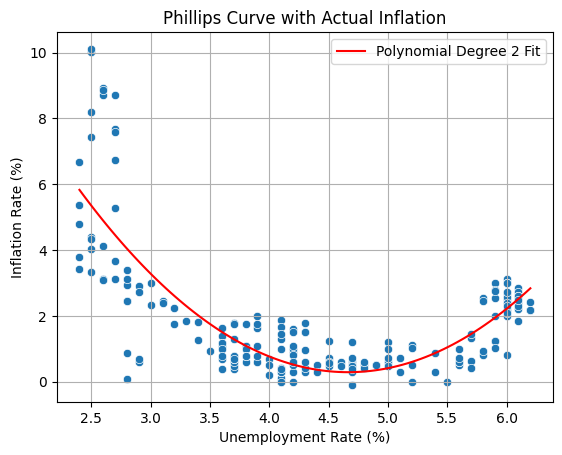

In [156]:
# We start out by dropping any rows with NaN values (just in case)
final_dataset.dropna(subset=['unemployment', 'inflation', 'fluctuation'], inplace=True)

# Choose a degree for polynomial fitting (usually 2 or 3 is chosen for the Phillips Curve)
degree = 2

# Fit a polynomial regression model to the data
coefficients = np.polyfit(final_dataset['unemployment'], final_dataset['inflation'], degree)
polynomial = np.poly1d(coefficients)

# Calculate the regression curve's y-values
x_values = np.linspace(final_dataset['unemployment'].min(), final_dataset['unemployment'].max(), 100)
y_poly = polynomial(x_values)

# Create the scatter plot
sns.scatterplot(x='unemployment', y='inflation', data=final_dataset)

# Plot the polynomial regression line
plt.plot(x_values, y_poly, color='red', label=f'Polynomial Degree {degree} Fit')

# Add labels and title
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Inflation Rate (%)')
plt.title('Phillips Curve with Actual Inflation')
plt.legend()
plt.grid(True)
plt.show()

When looking at the regression above, we see that the regression fits the Phillips curve for months with an unemployement rate under 4.5 precentage.  For months with an unemployement rate over 4.5 percentage the regression show a positiv correlation between the unemployment rate and the actual inflation. Because of this the Phillips curve breaks down, hence the empirical finding suggests that the theory is wrong for the given period. 

# The New Keynesian Phillips Curve

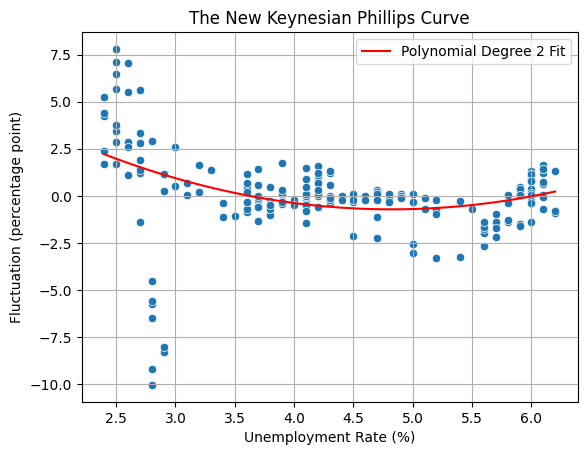

In [157]:
# Choose a degree for polynomial fitting (same as before)
degree = 2

# Fit a polynomial regression model to the data
coefficients = np.polyfit(final_dataset['unemployment'], final_dataset['fluctuation'], degree)
polynomial = np.poly1d(coefficients)

# Calculate the regression curve's y-values
x_values = np.linspace(final_dataset['unemployment'].min(), final_dataset['unemployment'].max(), 100)
y_poly = polynomial(x_values)

# Create the scatter plot
sns.scatterplot(x='unemployment', y='fluctuation', data=final_dataset)

# Plot the polynomial regression line
plt.plot(x_values, y_poly, color='red', label=f'Polynomial Degree {degree} Fit')

# Add labels and title
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Fluctuation (percentage point)')
plt.title('The New Keynesian Phillips Curve')
plt.legend()
plt.grid(True)
plt.show()

When looking at "The New Keynesian Phillips Curve" the correlation is negative when unemployment is under approx 4.5 percentages, which is the same as for the "normal" Phillips curve. After approx 4.5 percentages the correlation becomes positive, breaking the Phillips curve down. 

When comparing the two regressions the Phillips curve with actual inflation is closer to the expected results in the theory, than our New Keynesian Phillips Curve. This is due to the fact that the regression with actual inflation has a much stronger correlation between the two variables for months with an unemployement rate under approx 4.5 percentage. 

Since the New Keynesian Phillips Curve in mainstream economics is regarded as a superior Phillips curve, our assumption of the expected inflation being the inflation of the prior year is probably unrealistic. 

# Conclusion

We find that the Phillips curve do not allign with empirical data in the period Denmark 2007-2023. We also find: 
- When unemployment is over approx 4.5 percentage it do not work. 
- The Phillips Curve with acutal inflation is better allign with theory than our New Keynesian Phillips Curve. This suggests that our assumption regarding expected inflation is probably wrong.
- When unemployment is under approx 4.5 percentage, actual inflation in particular, is showing results alligning with the theory.  